In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.generation.sampling import MaxPosteriorSampling
from uncertaintylearning.utils import create_network, create_optimizer

from uncertaintylearning.models import DEUP, MCDropout
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KernelDensity

from torch.utils.data import DataLoader, TensorDataset
from torch.quasirandom import SobolEngine

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# from test_functions import functions
from examples.SMO.test_functions import functions, bounds as boundsx
from uncertaintylearning.features.feature_generator import FeatureGenerator
from examples.SMO.buffer import Buffer
from examples.SMO.smo import init_buffer, optimize, make_feature_generator, one_step_acquisition
from uncertaintylearning.models.mcdropout import MCDropout
from uncertaintylearning.models.ensemble import Ensemble

from copy import deepcopy
from itertools import product


In [10]:
# fct_name = 'levi_n13'
fct_name = 'multi_optima'
fct = functions[fct_name]
dim, bounds = boundsx[fct_name]
noise = 0
f = lambda x: fct(x, 0)
def invsoftplus(x, beta=1):
    return 1. / beta * (torch.log((beta * x).exp() - 1))

X = (bounds[1] - bounds[0]) * torch.rand(1000, dim) + bounds[0]
Y = f(X)
if dim == 1:
    X = torch.arange(bounds[0], bounds[1], 0.01).reshape(-1, 1)
    Y = f(X)

## COMPARE WITH MANY SEEDS TO GP

Seed 0, Y_init_max 0.243853360414505
Y_init_max 0.243853360414505


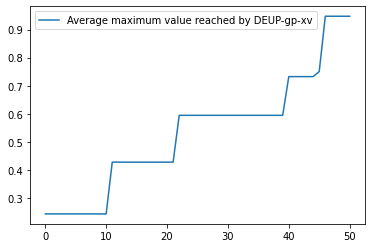

Seed 1, Y_init_max 0.44907984137535095
Y_init_max 0.44907984137535095


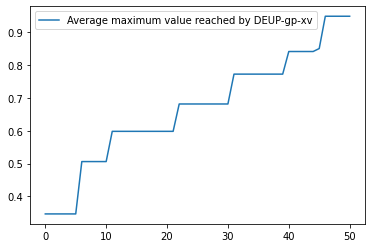

Seed 2, Y_init_max 0.2930920720100403
Y_init_max 0.2930920720100403


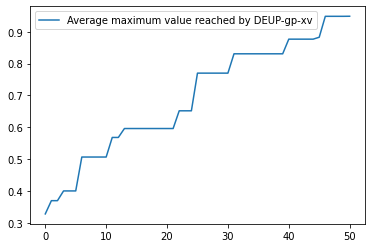

Seed 3, Y_init_max 0.632684051990509
Y_init_max 0.632684051990509


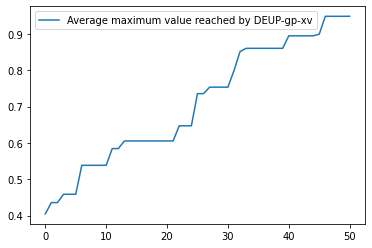

Seed 4, Y_init_max 0.6140106320381165
Y_init_max 0.6140106320381165


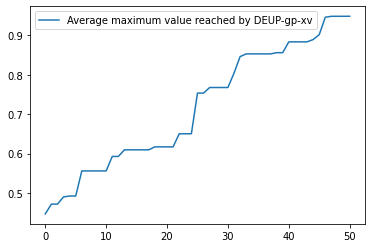

In [11]:
n_seeds = 5
n_steps = 50
res_gp = np.zeros((n_seeds, 1 + n_steps))

res_ensemble = np.zeros((n_seeds, 1 + n_steps))
res_mcdropout = np.zeros((n_seeds, 1 + n_steps))
    
res_gpdeup = np.zeros((n_seeds, 1 + n_steps))
use_log_unc=True
features = 'xv'

for seed in range(n_seeds):
    torch.manual_seed(10 + seed)
    X_init = (bounds[1] - bounds[0]) * torch.rand(6, dim) + bounds[0]
    Y_init = f(X_init)
    
    print(f'Seed {seed}, Y_init_max {Y_init.max().item()}')
    # outs_gp = optimize(f, bounds, X_init, Y_init, model_type="gp", plot_stuff=False, domain=X, domain_image=Y, n_steps=n_steps)
    # res_gp[seed] = outs_gp[0]
    
    # nets = [create_network(dim, 1, 128, 'relu', False, 3) for i in range(3)]
    # opts = [create_optimizer(nets[i], 1e-3) for i in range(3)]
    # print(f'Seed {seed}, Y_init_max {Y_init.max().item()}')
    # outs_gp = optimize(f, bounds, X_init, Y_init, model_type="ensemble", networks=nets, optimizers=opts, features=features,
    #                epochs=200, plot_stuff=False, domain=X, domain_image=Y, n_steps=n_steps)
    # res_ensemble[seed] = outs_gp[0]

    # network = create_network(dim, 1, 128, 'relu', False, 3, 0.3)
    # optimizer = create_optimizer(network, 1e-3)
    # mcdropout_model = MCDropout(X_init, Y_init, network, optimizer, batch_size=64)
    # print(f'Seed {seed}, Y_init_max {Y_init.max().item()}')
    # outs_gp = optimize(f, bounds, X_init, Y_init, model_type="mcdropout", networks=network, optimizers=optimizer, features=features,
    #                epochs=200, plot_stuff=False, domain=X, domain_image=Y, n_steps=n_steps)
    # res_mcdropout[seed] = outs_gp[0]

    
    
    print(f'Y_init_max {Y_init.max().item()}')
    networks = {
    'e_predictor': create_network(len(features) + (dim - 1 if 'x' in features else 0),
                                  1, 128, 'relu', False if use_log_unc else True, 3),
    'f_predictor': create_network(dim, 1, 128, 'relu', False, 3)
    }
    optimizers = {
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-3),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
             }
    outs = optimize(f, bounds, X_init, Y_init, networks=networks, optimizers=optimizers, features=features, plot_stuff=False,
                    n_steps=n_steps, epochs=200, domain=X, domain_image=Y, print_each=100, use_log_unc=True, estimator='gp')
    res_gpdeup[seed] = outs[0]
    
    # plt.plot(range(1 + n_steps), res_gp[:seed+1].mean(0),  label='Average maximum value reached by GP')
    # plt.plot(range(1 + n_steps), res_ensemble[:seed+1].mean(0),  label='Average maximum value reached by Ensemble')
    # plt.plot(range(1 + n_steps), res_mcdropout[:seed+1].mean(0),  label='Average maximum value reached by MCDropout')
    plt.plot(range(1 + n_steps), res_gpdeup[:seed+1].mean(0), label='Average maximum value reached by DEUP-gp-xv')
    plt.legend()
    plt.show()


## IMPORT

In [14]:
import pickle
string = """
some information if you want
"""
pickle.dump({'gp': res_gp, 'gpdeup': res_gpdeup,
             'mcdropout': res_mcdropout, 'ensemble': res_ensemble, 'string': string,
            }, open('multi_optima.pkl', 'wb'))